In [1]:
import sys
import os
from ml4cvd.arguments import parse_args
from ml4cvd.recipes import run
import h5py
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Callable
from collections import defaultdict
import pandas as pd

from ml4cvd.arguments import _get_tmap
from ml4cvd.TensorMap import TensorMap
from ml4cvd.tensor_from_file import TMAPS

import numpy as np
USER = 'pdiachil'
HOME_PATH = '/home/' + USER

/usr/local/lib/python3.6/dist-packages/apache_beam/__init__.py:84: UserWarning: Running the Apache Beam SDK on Python 3 is not yet fully supported. You may encounter buggy behavior or missing features.
  'Running the Apache Beam SDK on Python 3 is not yet fully supported. '
Using TensorFlow backend.


In [2]:
# sys.argv = ['tensorize',
#             '--mode', 'tensorize_ludb',
#             '--xml_folder', f'{HOME_PATH}/ludb/',
#             '--output_folder', f'{HOME_PATH}/ludb_tensors/',
#             '--tensors', f'{HOME_PATH}/ludb_tensors/',
#             '--min_sample_id', '1', 
#             '--max_sample_id', '201'
#            ]
# args = parse_args()
# run(args)

['electric axis of the heart: left axis deviation left ventricular hypertrophy left ventricular overload non-specific repolarization abnormalities: posterior wall']


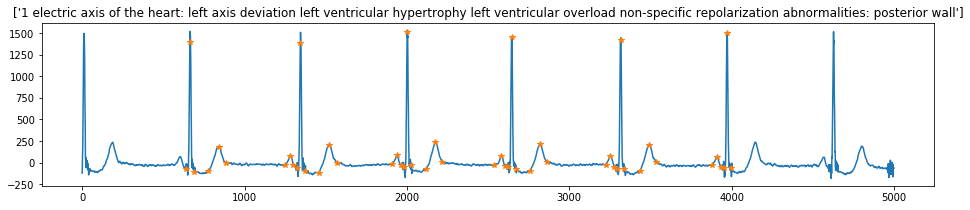

In [3]:
%matplotlib inline
for i in range(1, 200):
    with h5py.File(f'{HOME_PATH}/ludb_tensors/{i}.hd5', 'r') as hd5:
        f, ax = plt.subplots()
        f.set_size_inches(16, 3)
        ann = np.array(hd5['ecg_rest_annotation/annotation_i'])
        data = np.array(hd5['ecg_rest/strip_i'])
        ax.plot(data)
        ax.plot(ann, data[ann], '*')
        print(hd5['ecg_rest_text'][()])
        ax.set_title(str(i) + ' ' + hd5['ecg_rest_text'][()])
    break

In [4]:
def annotation_to_segmentation(data, ann, shape = (5000,)):
    cycle = ['QR', 'RS', 'ST1', 'T1T2', 'T2T3', 'T3P1', 'P1P2', 'P2P3', 'P3Q']
    parsed_data = np.zeros(shape)
    parsed_range = ann[-1] - ann[0]
    parsed_data[:parsed_range] = data[ann[0]:ann[-1]]
    segmented_data = np.zeros(shape, dtype=np.int)
    ic = 0
    for ia in range(len(ann)-1):
        segmented_data[ann[ia]-ann[0]:ann[ia+1]-ann[0]] = ic
        ic += 1
        if ic == len(cycle):
            ic = 0
    return parsed_data, segmented_data      

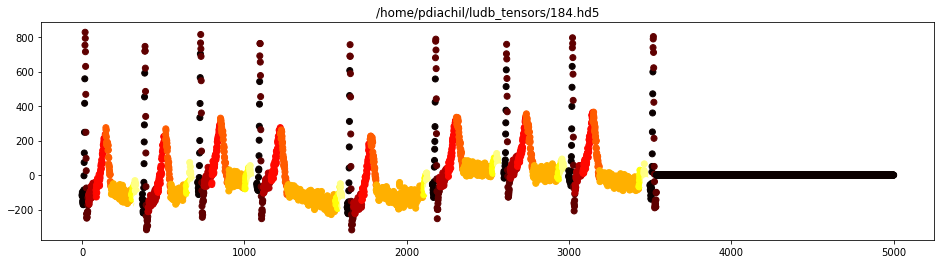

In [5]:
import glob
from matplotlib import cm
hd5_paths = glob.glob(f'{HOME_PATH}/ludb_tensors/*.hd5')
for hd5_path in hd5_paths:
    with h5py.File(hd5_path, 'r') as hd5:        
        ann = np.array(hd5['ecg_rest_annotation/annotation_i'])
        data = np.array(hd5['ecg_rest/strip_i'])
        parsed, segmented = annotation_to_segmentation(data, ann)
        f, ax = plt.subplots()
        f.set_size_inches(16, 4)
        ax.scatter(range(len(parsed)), parsed, c=cm.hot(segmented/8.0))
        ax.set_title(hd5_path)
        
    break

In [6]:
import glob
from ml4cvd.arguments import _get_tmap
hd5_paths = glob.glob(f'{HOME_PATH}/ludb_tensors/*.hd5')
tm_data = _get_tmap('ecg_rest_ludb')
tm_segmentation = _get_tmap('ecg_rest_ludb_segmentation_weighted')
for hd5_path in hd5_paths:
    with h5py.File(hd5_path, 'r') as hd5:
        data = tm_data.tensor_from_file(tm_data, hd5)
        segmentation = tm_segmentation.tensor_from_file(tm_segmentation, hd5)
    break

In [7]:
# sys.argv = ['train',
#             '--mode', 'train',
#             '--output_folder', f'{HOME_PATH}/ludb_output/',
#             '--tensors', f'{HOME_PATH}/ludb_tensors/',
#             '--input_tensors', 'ecg_rest_ludb',
#             '--output_tensors', 'ecg_rest_ludb_segmentation',
#             '--id', 'test_ludb_segmentation',
#             '--num_workers', '0',
#             '--inspect_model',
#             '--training_steps', '14',
#             '--validation_steps', '2',
#             '--test_steps', '2',
#             '--batch_size', '4',
#             '--epochs', '100'
#            ]
# args = parse_args()
# run(args)

In [8]:
def tmaps_by_sample_id(tensor_folder: str, sample_id: str, tmaps: List[TensorMap], dependent_tmap):
    path = os.path.join(tensor_folder, sample_id + '.hd5')
    result_dict = defaultdict(lambda: None)
    dependents = defaultdict(lambda: None)
    if os.path.isfile(path):
            with h5py.File(path, 'r') as hd5:
                for tmap in tmaps:
                    try:
                        result_dict[tmap] = tmap.tensor_from_file(tmap, hd5, dependents)
                        for dependent in dependents:
                            result_dict[dependent] = np.array(dependents[dependent])
                    except (IndexError, KeyError, ValueError, OSError, RuntimeError):
                        continue
    return result_dict


def tmaps_with_properties(tensor_folder: str, tmap_properties: Dict[TensorMap, Callable[[np.ndarray], bool]], search_size=100, dependent_tmap=None):
    all_ids = [file.strip('.hd5') for file in sorted(os.listdir(tensor_folder))[:search_size]]
    results = map(lambda sample_id: tmaps_by_sample_id(tensor_folder, sample_id, tmap_properties.keys(), dependent_tmap), all_ids)
    return {
        sample_id: result
        for sample_id, result in zip(all_ids, results)
        if all(
            result[tmap] is not None and tmap_properties[tmap](result[tmap])
            for tmap in tmap_properties.keys()
        )
    }


def tmaps_with_properties_from_keys(tensor_folder: str, tmap_properties: Dict[str, Callable[[np.ndarray], bool]], search_size=100, dependent_tmap=None):
    return tmaps_with_properties(
        tensor_folder,
        {_get_tmap(key): prop for key, prop in tmap_properties.items()},
        search_size, dependent_tmap
    )

def tmap_dic_to_dic(tmap_dic):
    sample_id = []
    tmaps = []
    tmap_names = []
    tmap_subcols = []
    out_dic = {'sample_id': []}
        
    for i, entry in enumerate(tmap_dic):
        for t in tmap_dic[entry]:
            nsubcols = np.prod(t.shape)
            for n in range(nsubcols):
                out_dic[t.name + '_' + str(n)] = np.zeros(len(tmap_dic))
        break
    
    for i, entry in enumerate(tmap_dic):
        out_dic['sample_id'].append(entry)
        for t in tmap_dic[entry]:   
            nsubcols = np.prod(t.shape)
            for n in range(nsubcols):
                out_dic[t.name + '_' + str(n)][i] = tmap_dic[entry][t].ravel()[n]
    return out_dic

In [9]:
a = tmaps_by_sample_id('/home/pdiachil/ludb_tensors/', '1', [_get_tmap('ecg_rest_ludb')], _get_tmap('ecg_rest_ludb_segmentation_coarse'))

b = tmaps_with_properties_from_keys(
    '/home/pdiachil/ludb_tensors/', 
    {
        'ecg_rest_ludb': lambda x: True,
    },
    search_size = 20,
    dependent_tmap = _get_tmap('ecg_rest_ludb_segmentation_coarse')
)

In [10]:
dd = tmap_dic_to_dic(b)
df = pd.DataFrame(dd)
df

,sample_id,ecg_rest_ludb_0,ecg_rest_ludb_1,ecg_rest_ludb_2,ecg_rest_ludb_3,ecg_rest_ludb_4,ecg_rest_ludb_5,ecg_rest_ludb_6,ecg_rest_ludb_7,ecg_rest_ludb_8,...,ecg_rest_ludb_segmentation_279990,ecg_rest_ludb_segmentation_279991,ecg_rest_ludb_segmentation_279992,ecg_rest_ludb_segmentation_279993,ecg_rest_ludb_segmentation_279994,ecg_rest_ludb_segmentation_279995,ecg_rest_ludb_segmentation_279996,ecg_rest_ludb_segmentation_279997,ecg_rest_ludb_segmentation_279998,ecg_rest_ludb_segmentation_279999
0,1,-0.007079,-0.007079,-0.007079,-0.007079,-0.007079,-0.007079,-0.007079,-0.007079,-0.007079,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,0.007687,0.007687,0.007687,0.007687,0.007687,0.007687,0.007687,0.007687,0.007687,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100,-0.501050,-0.500936,-0.084220,-0.084220,-0.501054,0.129446,0.129550,0.343375,-0.501220,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,102,-0.945277,-1.079702,0.206815,0.164791,-1.054558,-1.390896,-1.542291,0.391842,-0.963232,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,106,-0.235397,-0.211989,0.907090,0.616693,0.907060,0.251437,0.626141,-0.558434,-0.221996,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,107,-0.545738,-0.397131,1.454831,1.553791,1.860798,0.533695,0.087970,-0.793304,-0.555892,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,108,2.425523,-0.833964,1.773639,7.206007,6.010878,0.469861,1.990941,-0.616654,1.994390,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,11,-0.253617,0.153293,-0.067977,-0.324954,-0.335673,0.253215,-0.135861,-0.028737,-0.250895,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,113,-0.276098,-0.381515,-0.244515,-0.381520,-0.592325,-0.803177,-0.697728,-0.486852,-0.276650,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,119,0.005569,0.005569,0.005569,0.005569,0.005569,0.005569,0.005569,0.005569,0.005569,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# cols = [f'ecg_rest_ludb_segmentation_{i}' for i in range(0, 40000, 2)]
# df[cols].apply(pd.Series.value_counts)

In [12]:
# 2900000.0 / df[cols].apply(pd.Series.value_counts).sum(axis=1)/20.390944

In [13]:
# sys.argv = ['train',
#             '--mode', 'train',
#             '--output_folder', f'{HOME_PATH}/ludb_output/',
#             '--tensors', f'{HOME_PATH}/ludb_tensors/',
#             '--input_tensors', 'ecg_rest_ludb',
#             '--output_tensors', 'ecg_rest_ludb_segmentation_coarse',
#             '--id', 'test_ludb_coarse_segmentation_roll_wave',
#             '--num_workers', '0',
#             '--inspect_model',
#             '--training_steps', '15',
#             '--validation_steps', '5',
#             '--test_steps', '5',
#             '--batch_size', '8',
#             '--epochs', '400',
#             '--patience', '40'            
#            ]
# args = parse_args()
# run(args)

In [14]:
b = tmaps_with_properties_from_keys(
    '/mnt/disks/ecg-rest-37k-tensors/2019-11-04/', 
    {
        'ecg_rest_random_lead': lambda x: True,
    },
    search_size = 20,
    dependent_tmap = _get_tmap('ecg_lead_detection')
)
dd = tmap_dic_to_dic(b)
df = pd.DataFrame(dd)
df

,sample_id,strip_0,strip_1,strip_2,strip_3,strip_4,strip_5,strip_6,strip_7,strip_8,...,ecg_lead_detection_2,ecg_lead_detection_3,ecg_lead_detection_4,ecg_lead_detection_5,ecg_lead_detection_6,ecg_lead_detection_7,ecg_lead_detection_8,ecg_lead_detection_9,ecg_lead_detection_10,ecg_lead_detection_11
0,1000387,1.467355,1.420541,1.373728,1.342519,1.326915,1.326915,1.326915,1.358124,1.389332,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1000426,-0.112103,-0.175481,-0.270548,-0.365616,-0.428994,-0.460683,-0.428994,-0.333927,-0.333927,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1000503,0.129963,0.210842,0.251281,0.210842,0.129963,0.049085,0.008646,0.008646,0.049085,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1000800,-1.480955,-1.801633,-1.587848,-1.374063,-1.320616,-1.427509,-1.587848,-1.641294,-1.748187,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1001047,0.857028,0.827531,0.827531,0.857028,0.857028,0.798034,0.768538,0.798034,0.886525,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,1001080,2.046245,2.032362,2.046245,2.046245,2.004595,1.976829,1.976829,1.976829,2.004595,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1001187,1.391399,1.372952,1.372952,1.354504,1.372952,1.502081,1.594317,1.575870,1.538975,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1001278,-0.960027,-0.974710,-0.989394,-0.960027,-0.930660,-0.930660,-0.974710,-0.974710,-0.915977,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1001312,1.542144,1.590931,1.664111,1.712898,1.810472,1.883652,1.810472,1.664111,1.517751,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,1001467,-0.893175,-0.882499,-0.818438,-0.765054,-0.775731,-0.797084,-0.818438,-0.839791,-0.861145,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Lead detection

In [ ]:
sys.argv = ['train',
            '--mode', 'train',
            '--output_folder', f'{HOME_PATH}/ukbb_output/',
            '--tensors', f'/mnt/disks/ecg-rest-37k-tensors/2019-11-04/',
            '--input_tensors', 'ecg_rest_random_lead',
            '--output_tensors', 'ecg_lead_detection',
            '--id', 'ecg_lead_detection',
            '--inspect_model',
            '--training_steps', '810',
            '--validation_steps', '115',
            '--conv_z', '2',
            '--test_steps', '230',
            '--batch_size', '32',
            '--epochs', '50',
            '--patience', '12'            
           ]
args = parse_args()
run(args)

2020-01-29 14:24:08,195 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at /home/pdiachil/ukbb_output/ecg_lead_detection/log_2020-01-29_14-24_0.log.
2020-01-29 14:24:08,195 - arguments:207 - INFO - Command Line was:

./scripts/tf.sh train --mode train --output_folder /home/pdiachil/ukbb_output/ --tensors /mnt/disks/ecg-rest-37k-tensors/2019-11-04/ --input_tensors ecg_rest_random_lead --output_tensors ecg_lead_detection --id ecg_lead_detection --inspect_model --training_steps 810 --validation_steps 115 --conv_z 2 --test_steps 230 --batch_size 32 --epochs 50 --patience 12



2020-01-29 14:24:08,197 - arguments:208 - INFO - Total TensorMaps:396 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=32, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, cache_size=8

2020-01-29 14:24:09,732 - models:827 - INFO - Saving architecture diagram to:/home/pdiachil/ukbb_output/ecg_lead_detection/architecture_graph_ecg_lead_detection.png
Epoch 1/1
2020-01-29 14:24:13,037 - tensor_generators:110 - INFO - Starting validation_worker_0.
2020-01-29 14:24:13,039 - tensor_generators:110 - INFO - Starting train_worker_0.
2020-01-29 14:24:13,040 - tensor_generators:234 - INFO - validation_worker_0 initialized cache of size 0.067 GB.
2020-01-29 14:24:13,041 - tensor_generators:234 - INFO - train_worker_0 initialized cache of size 0.120 GB.
2020-01-29 14:24:13,075 - tensor_generators:110 - INFO - Starting train_worker_1.
2020-01-29 14:24:13,080 - tensor_generators:234 - INFO - train_worker_1 initialized cache of size 0.120 GB.
2020-01-29 14:24:13,134 - tensor_generators:110 - INFO - Starting train_worker_2.
2020-01-29 14:24:13,139 - tensor_generators:234 - INFO - train_worker_2 initialized cache of size 0.120 GB.
2020-01-29 14:24:13,140 - tensor_generators:110 - INFO 

	9.37 seconds elapsed.
608/810 [=====================>........] - ETA: 8s2020-01-29 14:26:56,111 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 3:
	The following errors occurred:
		
	Generator looped & shuffled over 3327 paths.
	3327 tensors were presented.
	The cache holds 0 out of a possible 6654 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	8.61 seconds elapsed.
610/810 [=====================>........] - ETA: 8s2020-01-29 14:26:56,167 - tensor_generators:301 - INFO - Worker validation_worker_1 - In true epoch 3:
	The following errors occurred:
		
	Generator looped & shuffled over 3327 paths.
	3327 tensors were presented.
	The cache holds 0 out of a possible 6654 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	8.60 seconds elapsed.
810/810 [==============================] - 35s 43ms/step
2020-01-29 14:27:04,440 - mode

184/810 [=====>........................] - ETA: 1:41 - loss: 1.4269 - categorical_accuracy: 0.4467 - strip_I_precision: 0.2940 - strip_II_precision: 0.1513 - strip_III_precision: 0.3057 - strip_V1_precision: 0.5215 - strip_V2_precision: 0.2434 - strip_V3_precision: 0.0217 - strip_V4_precision: 0.0888 - strip_V5_precision: 0.1134 - strip_V6_precision: 0.1183 - strip_aVF_precision: 0.0263 - strip_aVL_precision: 0.1676 - strip_aVR_precision: 0.8178 - strip_I_recall: 0.1969 - strip_II_recall: 0.0755 - strip_III_recall: 0.1388 - strip_V1_recall: 0.3670 - strip_V2_recall: 0.1466 - strip_V3_recall: 0.0120 - strip_V4_recall: 0.0461 - strip_V5_recall: 0.0857 - strip_V6_recall: 0.0909 - strip_aVF_recall: 0.0100 - strip_aVL_recall: 0.0702 - strip_aVR_recall: 0.78752020-01-29 14:29:52,341 - tensor_generators:301 - INFO - Worker train_worker_1 - In true epoch 3:
	The following errors occurred:
		
	Generator looped & shuffled over 5963 paths.
	5963 tensors were presented.
	The cache holds 0 out of a

	270.93 seconds elapsed.
810/810 [==============================] - 135s 166ms/step - loss: 1.3782 - categorical_accuracy: 0.4722 - strip_I_precision: 0.3953 - strip_II_precision: 0.2005 - strip_III_precision: 0.3295 - strip_V1_precision: 0.5377 - strip_V2_precision: 0.2616 - strip_V3_precision: 0.0662 - strip_V4_precision: 0.0663 - strip_V5_precision: 0.1059 - strip_V6_precision: 0.1844 - strip_aVF_precision: 0.0737 - strip_aVL_precision: 0.3690 - strip_aVR_precision: 0.8135 - strip_I_recall: 0.2755 - strip_II_recall: 0.1137 - strip_III_recall: 0.1715 - strip_V1_recall: 0.4112 - strip_V2_recall: 0.1529 - strip_V3_recall: 0.0312 - strip_V4_recall: 0.0298 - strip_V5_recall: 0.0727 - strip_V6_recall: 0.1267 - strip_aVF_recall: 0.0406 - strip_aVL_recall: 0.2270 - strip_aVR_recall: 0.7929 - val_loss: 1.2726 - val_categorical_accuracy: 0.5122 - val_strip_I_precision: 0.5212 - val_strip_II_precision: 0.4783 - val_strip_III_precision: 0.4222 - val_strip_V1_precision: 0.6445 - val_strip_V2_pre

243/810 [========>.....................] - ETA: 1:31 - loss: 1.2181 - categorical_accuracy: 0.5372 - strip_I_precision: 0.5696 - strip_II_precision: 0.3886 - strip_III_precision: 0.5182 - strip_V1_precision: 0.6248 - strip_V2_precision: 0.3265 - strip_V3_precision: 0.1413 - strip_V4_precision: 0.1859 - strip_V5_precision: 0.0938 - strip_V6_precision: 0.3737 - strip_aVF_precision: 0.2512 - strip_aVL_precision: 0.6121 - strip_aVR_precision: 0.8690 - strip_I_recall: 0.4662 - strip_II_recall: 0.2294 - strip_III_recall: 0.3579 - strip_V1_recall: 0.5356 - strip_V2_recall: 0.1957 - strip_V3_recall: 0.0659 - strip_V4_recall: 0.0845 - strip_V5_recall: 0.0627 - strip_V6_recall: 0.2533 - strip_aVF_recall: 0.1441 - strip_aVL_recall: 0.4831 - strip_aVR_recall: 0.86612020-01-29 14:34:31,701 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 6:
	The following errors occurred:
		
	Generator looped & shuffled over 5963 paths.
	5963 tensors were presented.
	The cache holds 0 out of a


Epoch 00004: val_loss did not improve from 1.20973
Epoch 5/50
547/810 [===================>..........] - ETA: 42s - loss: 1.1703 - categorical_accuracy: 0.5484 - strip_I_precision: 0.5884 - strip_II_precision: 0.4243 - strip_III_precision: 0.4892 - strip_V1_precision: 0.6073 - strip_V2_precision: 0.4143 - strip_V3_precision: 0.1720 - strip_V4_precision: 0.0854 - strip_V5_precision: 0.1273 - strip_V6_precision: 0.4315 - strip_aVF_precision: 0.2735 - strip_aVL_precision: 0.7237 - strip_aVR_precision: 0.8590 - strip_I_recall: 0.4961 - strip_II_recall: 0.2862 - strip_III_recall: 0.3611 - strip_V1_recall: 0.5293 - strip_V2_recall: 0.2598 - strip_V3_recall: 0.0836 - strip_V4_recall: 0.0425 - strip_V5_recall: 0.0730 - strip_V6_recall: 0.2845 - strip_aVF_recall: 0.1643 - strip_aVL_recall: 0.5908 - strip_aVR_recall: 0.84332020-01-29 14:37:35,148 - tensor_generators:301 - INFO - Worker train_worker_1 - In true epoch 8:
	The following errors occurred:
		
	Generator looped & shuffled over 5963 pa

305/810 [==========>...................] - ETA: 1:21 - loss: 1.1400 - categorical_accuracy: 0.5619 - strip_I_precision: 0.6230 - strip_II_precision: 0.4070 - strip_III_precision: 0.5483 - strip_V1_precision: 0.6710 - strip_V2_precision: 0.4240 - strip_V3_precision: 0.1730 - strip_V4_precision: 0.1689 - strip_V5_precision: 0.0339 - strip_V6_precision: 0.5141 - strip_aVF_precision: 0.2847 - strip_aVL_precision: 0.6736 - strip_aVR_precision: 0.8296 - strip_I_recall: 0.5189 - strip_II_recall: 0.2605 - strip_III_recall: 0.4455 - strip_V1_recall: 0.5815 - strip_V2_recall: 0.3082 - strip_V3_recall: 0.0884 - strip_V4_recall: 0.0791 - strip_V5_recall: 0.0194 - strip_V6_recall: 0.3646 - strip_aVF_recall: 0.1707 - strip_aVL_recall: 0.5851 - strip_aVR_recall: 0.80642020-01-29 14:39:10,627 - tensor_generators:301 - INFO - Worker train_worker_3 - In true epoch 9:
	The following errors occurred:
		
	Generator looped & shuffled over 5963 paths.
	5963 tensors were presented.
	The cache holds 0 out of a